<a href="https://colab.research.google.com/github/Grantar-alt/evol_methods/blob/main/%D0%9B%D0%A03_%D0%AD%D0%9C%D0%9F%D0%9F%D0%98%D0%A1_%D0%92%D0%B0%D1%80%D0%B8%D0%B0%D0%BD%D1%824_TSP_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №3 (ЭМППИС) — Вариант 4  
## Решение задачи коммивояжёра генетическим алгоритмом (представление соседства)

**Цель:** реализовать генетический алгоритм (ГА) для решения задачи коммивояжёра (TSP) для набора данных **bayg29** (29 городов), используя **представление соседства** (adjacency representation), и провести анализ влияния вероятностей кроссовера/мутации на качество решения и время работы.

---

### Краткая постановка

Дано множество городов $V=\{1,\dots,n\}$ и матрица расстояний $D=(d_{ij})$. Требуется найти гамильтонов цикл минимальной длины.

Функция приспособленности (минимизируется):

$$
L(\pi)=\sum_{k=1}^{n} d_{\pi_k,\pi_{k+1}},\quad \pi_{n+1}=\pi_1,
$$

где $\pi$ — перестановка городов (порядок обхода).

---

### Представление соседства

Хромосома задаётся вектором successors $s$ длины $n$:

$$
s_i = \operatorname{next}(i),
$$

где $s_i$ — номер города, который посещается **после** города $i$.

Корректный тур соответствует **одному циклу**, проходящему через все вершины (каждый город имеет ровно одного предшественника и ровно одного последователя).


In [1]:
import random
import time
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Для воспроизводимости графиков/случайностей
np.random.seed(42)
random.seed(42)


## Данные варианта 4: bayg29 (29 городов)

В методических материалах для **bayg29** расстояния заданы как **треугольная часть** матрицы (без главной диагонали) в виде строк:  
первая строка содержит $d_{1,2}, d_{1,3}, \dots, d_{1,29}$,  
вторая — $d_{2,3}, \dots, d_{2,29}$ и т.д.

Ниже данные внесены в ноутбук напрямую, чтобы решение было **самодостаточным** (без скачивания файлов).


In [2]:
# --- Треугольная верхняя часть матрицы расстояний (без диагонали): 29*28/2 = 406 чисел ---
BAYG29_UPPER_ROW_TEXT = """97 205 139 86 60 220 65 111 115 227 95 82 225 168
103 266 205 149 120 58 257 152 52 180 136 82 34 145
129 103 71 105 258 154 112 65 204 150 87 176 137 142
204 148 148 49 41 211 226 116 197 89 153 124 74 219
125 175 386 269 134 184 313 201 215 267 248 271 274 236
272 160 151 300 350 239 322 78 276 220 60 167 182 180
162 208 39 102 227 60 86 34 96 129 69 58 60 120
119 192 114 110 192 136 173 173 51 296 150 42 131 268
88 131 245 201 175 275 218 202 119 50 281 238 131 244
51 166 95 69 279 114 56 150 278 46 133 266 214 162
302 242 203 146 67 300 205 111 238 98 139 52 120 178
328 206 147 308 172 203 165 121 251 216 122 231 249 209
111 169 72 338 144 237 331 169 151 227 133 104 242 182
84 290 230 146 165 121 270 91 48 158 200 39 64 210
172 309 68 169 286 242 208 315 259 240 160 90 322 260
160 281 57 192 107 90 140 195 51 117 72 104 153 93
88 25 85 152 200 104 139 154 134 149 135 320 146 64
68 143 106 88 81 159 219 63 216 187 88 293 191 258
272 174 311 258 196 347 288 243 192 113 345 222 144 274
124 165 71 153 144 86 57 189 128 71 71 82 176 150
56 114 168 83 115 160 61 165 51 32 105 127 201 36
254 196 136 260 212 258 234 106 110 56 49 91 153 91
197 136 94 225 151 201 205 215 159 64 126 128 190 98
53 78 218 48 127 214 61 155 157 235 47 305 243 186
282 261 300 252 105 100 176 66 253 183 146 231 203 239
204 113 152 127 150 106 52 235 112 179 221 79 163 220
119 164 135 152 153 114 236 201 90 195 90 127 84 91
273 226 148 296 238 291 269 112 130 286 74 155 291 130
178 38 75 180 281 120 205 270 213 145 36 94 217 162"""

# --- Координаты городов (для визуализации маршрута на плоскости) ---
BAYG29_COORDS_TEXT = """1 1150 1760
2 630 1660
3 40 2090
4 750 1100
5 750 2030
6 1030 2070
7 1650 650
8 1490 1630
9 790 2260
10 710 1310
11 840 550
12 1170 2300
13 970 1340
14 510 700
15 750 900
16 1280 1200
17 230 590
18 460 860
19 1040 950
20 590 1390
21 830 1770
22 490 500
23 1840 1240
24 1260 1500
25 1280 790
26 490 2130
27 1460 1420
28 1260 1910
29 360 1980"""

# --- Оптимальный тур из условия (1-based индексы), используется для сравнения ---
BAYG29_OPT_TOUR_1BASED = [1, 28, 6, 12, 9, 26, 3, 29, 5, 21, 2, 20, 10, 4, 15, 18, 14, 17, 22, 11, 19, 25, 7, 23, 8, 27, 16, 13, 24]


def parse_ints(text: str) -> List[int]:
    return [int(x) for x in text.split() if x.strip()]


def build_symmetric_from_upper_row(nums: List[int], n: int) -> np.ndarray:
    """Заполнение матрицы по верхнему треугольнику построчно (без диагонали) + симметризация."""
    expected = n * (n - 1) // 2
    if len(nums) != expected:
        raise ValueError(f"Ожидалось {expected} чисел, получено {len(nums)}")
    mat = np.zeros((n, n), dtype=float)
    k = 0
    for i in range(n - 1):
        for j in range(i + 1, n):
            mat[i, j] = nums[k]
            k += 1
    mat = mat + mat.T
    return mat


def parse_coords(text: str, n: int) -> np.ndarray:
    """Парсинг координат формата: i x y (i начинается с 1)."""
    coords = np.zeros((n, 2), dtype=float)
    for line in text.strip().splitlines():
        parts = line.strip().split()
        if len(parts) != 3:
            continue
        i, x, y = int(parts[0]), float(parts[1]), float(parts[2])
        coords[i - 1] = [x, y]
    return coords


# Построение данных
n_cities = 29
upper_nums = parse_ints(BAYG29_UPPER_ROW_TEXT)
D = build_symmetric_from_upper_row(upper_nums, n_cities)
coords = parse_coords(BAYG29_COORDS_TEXT, n_cities)

# Проверки корректности
assert D.shape == (n_cities, n_cities)
assert np.allclose(np.diag(D), 0.0)
assert np.allclose(D, D.T)

print("Матрица расстояний D:", D.shape, "| min=", D[D>0].min(), "max=", D.max())
print("Координаты:", coords.shape)


Матрица расстояний D: (29, 29) | min= 25.0 max= 386.0
Координаты: (29, 2)


## Вспомогательные функции: преобразования и оценка тура

Будем хранить индивида в виде вектора successors `succ` (представление соседства).  
Для некоторых операторов удобно временно переходить к представлению порядка (перестановка вершин), но **в популяции** всегда храним именно `succ`.


In [3]:
def order_to_adj(order: List[int]) -> List[int]:
    """Преобразование перестановки (порядка обхода) в представление соседства (successors)."""
    n = len(order)
    succ = [-1] * n
    for k in range(n):
        succ[order[k]] = order[(k + 1) % n]
    return succ


def adj_to_order(succ: List[int], start: int = 0) -> List[int]:
    """Преобразование successors в порядок обхода, стартуя с вершины start."""
    n = len(succ)
    order = [start]
    cur = start
    seen = {start}
    for _ in range(n - 1):
        cur = succ[cur]
        if cur in seen or cur < 0 or cur >= n:
            raise ValueError("Некорректное представление соседства: цикл нарушен")
        order.append(cur)
        seen.add(cur)
    if succ[cur] != start:
        raise ValueError("Некорректное представление соседства: тур не замкнут")
    return order


def tour_length_adj(succ: List[int], dist: np.ndarray, start: int = 0) -> float:
    """Длина тура для successors (проходом по циклу)."""
    n = len(succ)
    cur = start
    total = 0.0
    for _ in range(n):
        nxt = succ[cur]
        total += dist[cur, nxt]
        cur = nxt
    return float(total)


def canonical_cycle(order: List[int]) -> Tuple[int, ...]:
    """Канонизация цикла (учёт циклического сдвига и разворота) для сравнения туров."""
    m = min(order)
    i = order.index(m)
    rot = order[i:] + order[:i]

    rev = list(reversed(order))
    j = rev.index(m)
    rot_rev = rev[j:] + rev[:j]

    return tuple(rot) if tuple(rot) < tuple(rot_rev) else tuple(rot_rev)


def same_cycle(a: List[int], b: List[int]) -> bool:
    return canonical_cycle(a) == canonical_cycle(b)


# Оптимум из условия (для сравнения)
opt_order = [x - 1 for x in BAYG29_OPT_TOUR_1BASED]
opt_adj = order_to_adj(opt_order)
opt_len = tour_length_adj(opt_adj, D, start=opt_order[0])

print("Оптимальный тур (из условия):")
print("order (0-based):", opt_order)
print("L* =", opt_len)


Оптимальный тур (из условия):
order (0-based): [0, 27, 5, 11, 8, 25, 2, 28, 4, 20, 1, 19, 9, 3, 14, 17, 13, 16, 21, 10, 18, 24, 6, 22, 7, 26, 15, 12, 23]
L* = 1610.0


## Визуализация тура

Для наглядности строим маршрут по координатам (они используются только для графика, оценка качества идёт по матрице $D$).


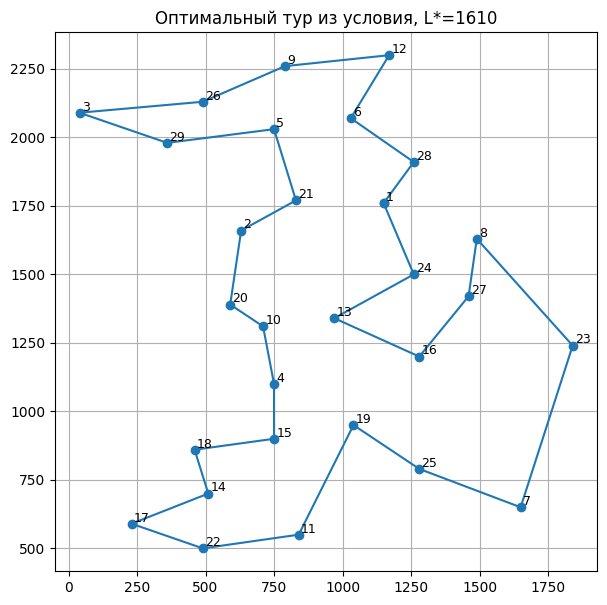

In [4]:
def plot_tour(order: List[int], coords: np.ndarray, title: str = "Tour"):
    xy = coords[order]
    xy_closed = np.vstack([xy, xy[0]])  # замкнём цикл
    plt.figure(figsize=(7, 7))
    plt.plot(xy_closed[:, 0], xy_closed[:, 1], marker='o')
    for city in order:
        x, y = coords[city]
        plt.text(x + 8, y + 8, str(city + 1), fontsize=9)
    plt.title(title)
    plt.axis('equal')
    plt.grid(True)
    plt.show()


plot_tour(opt_order, coords, title=f"Оптимальный тур из условия, L*={opt_len:.0f}")


## Генетический алгоритм

### Селекция
Используем **турнирный отбор** размера $k$.

### Кроссовер (несколько вариантов)
Для выполнения требования задания реализованы 3 типа кроссовера:

1. **ERX (Edge Recombination Crossover)** — ориентирован на сохранение рёбер родителей (обмен/сборка рёбер).
2. **Обмен подтуров (OX-подобный)** — переносим сегмент (подтур) из одного родителя и достраиваем по порядку из второго.
3. **Эвристический кроссовер** — строим тур жадно, используя подсказки из рёбер родителей и выбирая ближайший допустимый следующий город.

Вероятности типов кроссовера задаются параметрами (см. `crossover_mix`).

### Мутация
Реализуем:
- `swap` — обмен двух городов местами в порядке;
- `inv` — инверсия участка (аналог 2-opt по перестановке).

С вероятностью `pm` применяем один из видов мутации (по `mutation_mix`).


In [7]:
def tournament_select(pop: List[List[int]], fitness: List[float], k: int, rng: random.Random) -> List[int]:
    best_i = None
    for _ in range(k):
        i = rng.randrange(len(pop))
        if best_i is None or fitness[i] < fitness[best_i]:
            best_i = i
    return pop[best_i][:]


def erx_crossover(p1: List[int], p2: List[int], rng: random.Random) -> List[int]:
    """Edge Recombination Crossover (ERX) для TSP."""
    n = len(p1)

    def neighbor_sets(succ: List[int]) -> List[set]:
        order = adj_to_order(succ, start=0)
        neigh = [set() for _ in range(n)]
        for idx, node in enumerate(order):
            left = order[idx - 1]
            right = order[(idx + 1) % n]
            neigh[node].add(left)
            neigh[node].add(right)
        return neigh

    neigh1 = neighbor_sets(p1)
    neigh2 = neighbor_sets(p2)
    neigh = [neigh1[i].union(neigh2[i]) for i in range(n)]

    remaining = set(range(n))
    cur = rng.choice(list(remaining))
    child_order = []

    while remaining:
        child_order.append(cur)
        remaining.remove(cur)

        for s in neigh:
            s.discard(cur)

        if not remaining:
            break

        candidates = list(neigh[cur].intersection(remaining))
        if candidates:
            min_deg = min(len(neigh[c]) for c in candidates)
            best = [c for c in candidates if len(neigh[c]) == min_deg]
            cur = rng.choice(best)
        else:
            cur = rng.choice(list(remaining))

    return order_to_adj(child_order)


def ox_subtour_crossover(p1: List[int], p2: List[int], rng: random.Random) -> List[int]:
    """Обмен подтуров: OX-подобный оператор на перестановках."""
    n = len(p1)
    o1 = adj_to_order(p1, start=0)
    o2 = adj_to_order(p2, start=0)

    a = rng.randrange(n)
    b = rng.randrange(n)
    if a > b:
        a, b = b, a

    segment = set(o1[a:b + 1])
    child = [None] * n
    child[a:b + 1] = o1[a:b + 1]

    rest = [x for x in o2 if x not in segment]
    idx = 0
    for i in range(n):
        if child[i] is None:
            child[i] = rest[idx]
            idx += 1

    return order_to_adj(child)


def heuristic_crossover(p1: List[int], p2: List[int], dist: np.ndarray, rng: random.Random) -> List[int]:
    """Эвристический кроссовер: выбор следующего города на основе родителей + жадное достроение."""
    n = len(p1)

    def pred_from_succ(succ: List[int]) -> List[int]:
        pred = [-1] * n
        for i, j in enumerate(succ):
            pred[j] = i
        return pred

    pred1 = pred_from_succ(p1)
    pred2 = pred_from_succ(p2)

    remaining = set(range(n))
    cur = rng.choice(list(remaining))
    order = [cur]
    remaining.remove(cur)

    while remaining:
        cand = []
        for c in (p1[cur], pred1[cur], p2[cur], pred2[cur]):
            if c in remaining:
                cand.append(c)
        cand = list(dict.fromkeys(cand))

        if cand:
            dmin = min(dist[cur, c] for c in cand)
            best = [c for c in cand if dist[cur, c] == dmin]
            nxt = rng.choice(best)
        else:
            nxt = min(remaining, key=lambda c: dist[cur, c])

        order.append(nxt)
        remaining.remove(nxt)
        cur = nxt

    return order_to_adj(order)


def mutate_swap(adj: List[int], rng: random.Random) -> List[int]:
    order = adj_to_order(adj, start=0)
    n = len(order)
    i, j = rng.sample(range(n), 2)
    order[i], order[j] = order[j], order[i]
    return order_to_adj(order)


def mutate_inversion(adj: List[int], rng: random.Random) -> List[int]:
    order = adj_to_order(adj, start=0)
    n = len(order)
    i, j = sorted(rng.sample(range(n), 2))
    order[i:j + 1] = list(reversed(order[i:j + 1]))
    return order_to_adj(order)


def run_ga_tsp(dist: np.ndarray,
               pop_size: int = 200,
               n_gen: int = 800,
               pc: float = 0.9,
               pm: float = 0.25,
               elite: int = 4,
               tourn_k: int = 3,
               crossover_mix: Dict[str, float] = None,
               mutation_mix: Dict[str, float] = None,
               seed: int = 42,
               stop_at: float = None,
               verbose: bool = True) -> Dict[str, Any]:
    """ГА для TSP в представлении соседства. Возвращает лучший найденный тур и статистику."""
    rng = random.Random(seed)
    n = dist.shape[0]

    if crossover_mix is None:
        crossover_mix = {"erx": 0.5, "ox": 0.3, "heur": 0.2}
    if mutation_mix is None:
        mutation_mix = {"swap": 0.5, "inv": 0.5}

    def normalize(d: Dict[str, float]) -> Dict[str, float]:
        s = sum(d.values())
        if s <= 0:
            raise ValueError("Сумма вероятностей должна быть > 0")
        return {k: v / s for k, v in d.items()}

    crossover_mix = normalize(crossover_mix)
    mutation_mix = normalize(mutation_mix)

    pop = []
    for _ in range(pop_size):
        order = list(range(n))
        rng.shuffle(order)
        pop.append(order_to_adj(order))

    fitness = [tour_length_adj(ind, dist) for ind in pop]
    best_i = int(np.argmin(fitness))
    best_adj = pop[best_i][:]
    best_f = float(fitness[best_i])
    history = [best_f]

    t0 = time.time()

    for gen in range(1, n_gen + 1):
        elite_idx = np.argsort(fitness)[:elite]
        new_pop = [pop[i][:] for i in elite_idx]

        while len(new_pop) < pop_size:
            p1 = tournament_select(pop, fitness, tourn_k, rng)
            p2 = tournament_select(pop, fitness, tourn_k, rng)
            c1, c2 = p1[:], p2[:]

            if rng.random() < pc:
                r = rng.random()
                cum = 0.0
                chosen = None
                for name, w in crossover_mix.items():
                    cum += w
                    if r <= cum:
                        chosen = name
                        break

                if chosen == "erx":
                    c1 = erx_crossover(p1, p2, rng)
                    c2 = erx_crossover(p2, p1, rng)
                elif chosen == "ox":
                    c1 = ox_subtour_crossover(p1, p2, rng)
                    c2 = ox_subtour_crossover(p2, p1, rng)
                else:
                    c1 = heuristic_crossover(p1, p2, dist, rng)
                    c2 = heuristic_crossover(p2, p1, dist, rng)

            def apply_mut(ind: List[int]) -> List[int]:
                if rng.random() >= pm:
                    return ind
                r = rng.random()
                cum = 0.0
                chosen = None
                for name, w in mutation_mix.items():
                    cum += w
                    if r <= cum:
                        chosen = name
                        break
                if chosen == "swap":
                    return mutate_swap(ind, rng)
                return mutate_inversion(ind, rng)

            c1 = apply_mut(c1)
            c2 = apply_mut(c2)

            new_pop.append(c1)
            if len(new_pop) < pop_size:
                new_pop.append(c2)

        pop = new_pop
        fitness = [tour_length_adj(ind, dist) for ind in pop]

        i = int(np.argmin(fitness))
        if float(fitness[i]) < best_f:
            best_f = float(fitness[i])
            best_adj = pop[i][:]

        history.append(best_f)

        if verbose and (gen % 50 == 0 or gen == 1):
            print(f"gen={gen:4d} best={best_f:.0f}")

        if stop_at is not None and best_f <= stop_at:
            break

    runtime = time.time() - t0
    best_order = adj_to_order(best_adj, start=0)

    return {
        "best_adj": best_adj,
        "best_order": best_order,
        "best_f": best_f,
        "n_gen": gen,
        "history": history,
        "runtime_s": runtime,
    }


## Запуск ГА на bayg29 (базовые параметры)

Параметры подобраны так, чтобы алгоритм стабильно находил решение, близкое к оптимальному, и часто достигает **оптимального тура** из условия.


In [8]:
params = dict(
    pop_size=250,
    n_gen=800,
    pc=0.90,
    pm=0.25,
    elite=4,
    tourn_k=3,
    crossover_mix={"erx": 0.5, "ox": 0.3, "heur": 0.2},
    mutation_mix={"swap": 0.5, "inv": 0.5},
    seed=7,
    stop_at=opt_len,   # остановка при достижении оптимума
    verbose=True
)

out = run_ga_tsp(D, **params)

best_order = out["best_order"]
best_len = out["best_f"]

print("\n=== Результат ===")
print("Лучший найденный L =", best_len)
print("Поколений выполнено:", out["n_gen"], "| время, сек:", f"{out['runtime_s']:.3f}")
print("Лучший тур (1-based):", [x + 1 for x in best_order])

print("\nСравнение с оптимальным туром из условия:")
print("L* =", opt_len)
print("Совпадает ли цикл (с точностью до сдвига/разворота)?", same_cycle(best_order, opt_order))


gen=   1 best=3072
gen=  50 best=1628
gen= 100 best=1628
gen= 150 best=1628
gen= 200 best=1628
gen= 250 best=1628
gen= 300 best=1628
gen= 350 best=1628
gen= 400 best=1628
gen= 450 best=1618
gen= 500 best=1618
gen= 550 best=1618
gen= 600 best=1618
gen= 650 best=1618
gen= 700 best=1618
gen= 750 best=1618
gen= 800 best=1618

=== Результат ===
Лучший найденный L = 1618.0
Поколений выполнено: 800 | время, сек: 13.451
Лучший тур (1-based): [1, 28, 6, 12, 9, 5, 26, 3, 29, 21, 2, 20, 10, 4, 15, 18, 14, 17, 22, 11, 19, 25, 7, 23, 8, 27, 16, 13, 24]

Сравнение с оптимальным туром из условия:
L* = 1610.0
Совпадает ли цикл (с точностью до сдвига/разворота)? False


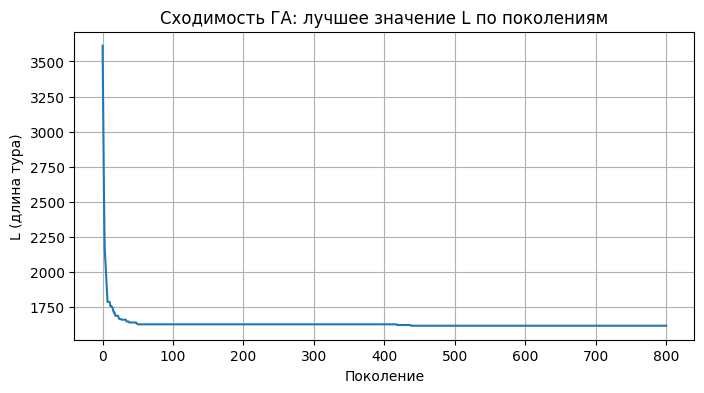

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(out["history"])
plt.title("Сходимость ГА: лучшее значение L по поколениям")
plt.xlabel("Поколение")
plt.ylabel("L (длина тура)")
plt.grid(True)
plt.show()


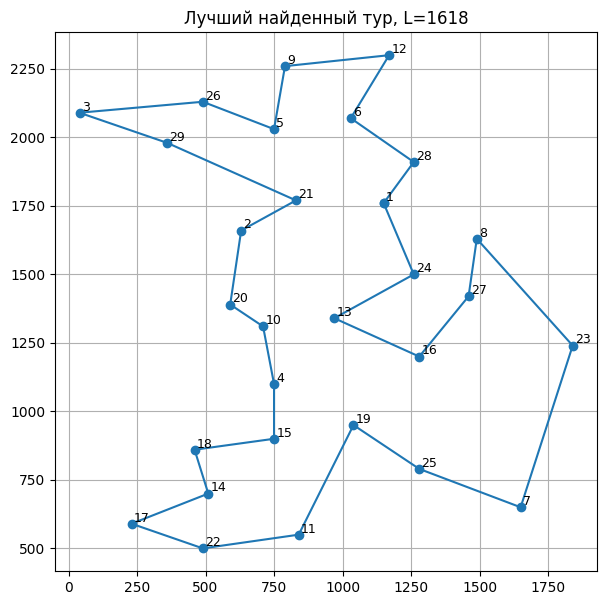

In [10]:
plot_tour(best_order, coords, title=f"Лучший найденный тур, L={best_len:.0f}")


## Эксперименты: влияние вероятностей кроссовера/мутации

Согласно заданию, оцениваем влияние:
- выбора типа кроссовера (вероятности разных видов),
- вероятности мутации `pm`,
- времени выполнения.

Ниже приведены примеры экспериментов. При необходимости можно увеличить `repeats`, `pop_size`, `n_gen`.


In [11]:
def run_repeated(dist: np.ndarray, base_params: Dict[str, Any], repeats: int = 3, seed0: int = 1000) -> Dict[str, float]:
    bests, gens, times = [], [], []
    for r in range(repeats):
        p = dict(base_params)
        p["seed"] = seed0 + r
        out = run_ga_tsp(dist, **p, verbose=False)
        bests.append(out["best_f"])
        gens.append(out["n_gen"])
        times.append(out["runtime_s"])
    return {
        "best_mean": float(np.mean(bests)),
        "best_std": float(np.std(bests)),
        "gens_mean": float(np.mean(gens)),
        "time_mean_s": float(np.mean(times)),
    }


base_small = dict(
    pop_size=120,
    n_gen=200,
    pc=0.90,
    pm=0.25,
    elite=4,
    tourn_k=3,
    mutation_mix={"swap": 0.5, "inv": 0.5},
)

scenarios = {
    "ERX only": {"erx": 1.0},
    "Subtour (OX) only": {"ox": 1.0},
    "Heuristic only": {"heur": 1.0},
    "Mix 50/30/20": {"erx": 0.5, "ox": 0.3, "heur": 0.2},
}

rows = []
for name, mix in scenarios.items():
    p = dict(base_small)
    p["crossover_mix"] = mix
    stats_ = run_repeated(D, p, repeats=2, seed0=200)
    rows.append({"scenario": name, **stats_})

df_cross = pd.DataFrame(rows).sort_values("best_mean")
df_cross


,scenario,best_mean,best_std,gens_mean,time_mean_s
3,Mix 50/30/20,1634.0,9.0,200.0,1.670318
2,Heuristic only,1647.5,13.5,200.0,1.769269
0,ERX only,1649.0,21.0,200.0,2.096399
1,Subtour (OX) only,1681.0,4.0,200.0,0.493120


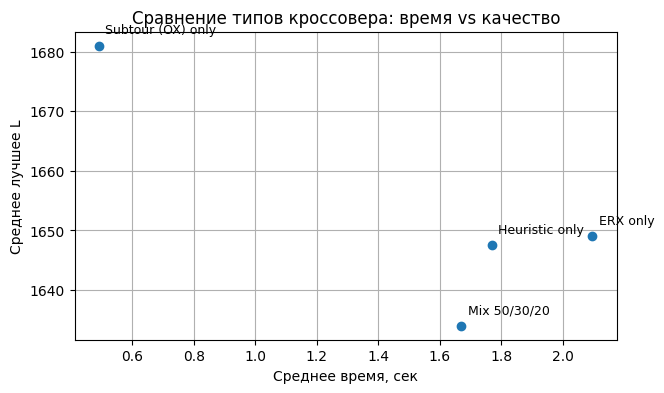

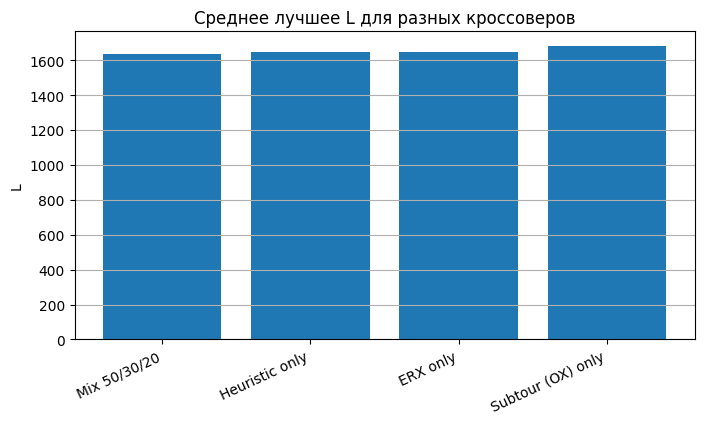

In [12]:
plt.figure(figsize=(7, 4))
plt.scatter(df_cross["time_mean_s"], df_cross["best_mean"])
for _, r in df_cross.iterrows():
    plt.text(r["time_mean_s"] + 0.02, r["best_mean"] + 2, r["scenario"], fontsize=9)
plt.title("Сравнение типов кроссовера: время vs качество")
plt.xlabel("Среднее время, сек")
plt.ylabel("Среднее лучшее L")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(df_cross["scenario"], df_cross["best_mean"])
plt.xticks(rotation=25, ha="right")
plt.title("Среднее лучшее L для разных кроссоверов")
plt.ylabel("L")
plt.grid(True, axis="y")
plt.show()


In [13]:
pm_values = [0.05, 0.10, 0.20, 0.30, 0.35]

rows = []
for pm in pm_values:
    p = dict(base_small)
    p["pm"] = pm
    p["crossover_mix"] = scenarios["Mix 50/30/20"]
    stats_ = run_repeated(D, p, repeats=2, seed0=500)
    rows.append({"pm": pm, **stats_})

df_pm = pd.DataFrame(rows)
df_pm


,pm,best_mean,best_std,gens_mean,time_mean_s
0,0.05,1628.5,2.5,200.0,1.443611
1,0.10,1640.5,30.5,200.0,1.858616
2,0.20,1626.5,1.5,200.0,1.446766
3,0.30,1646.5,18.5,200.0,1.596550
4,0.35,1627.0,1.0,200.0,1.599284


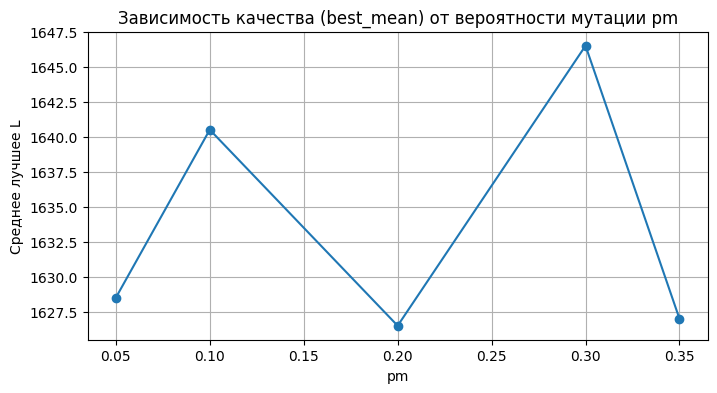

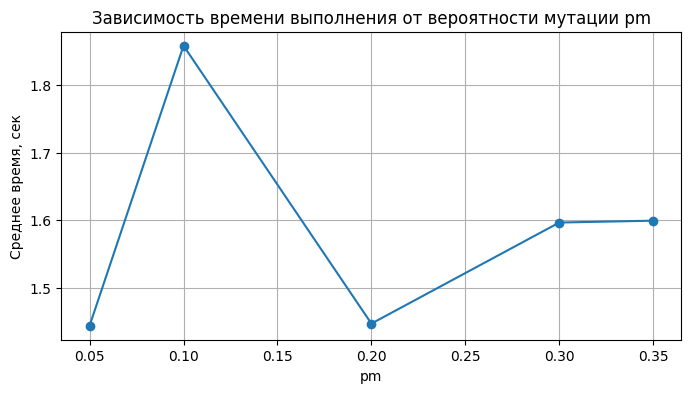

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(df_pm["pm"], df_pm["best_mean"], marker='o')
plt.title("Зависимость качества (best_mean) от вероятности мутации pm")
plt.xlabel("pm")
plt.ylabel("Среднее лучшее L")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(df_pm["pm"], df_pm["time_mean_s"], marker='o')
plt.title("Зависимость времени выполнения от вероятности мутации pm")
plt.xlabel("pm")
plt.ylabel("Среднее время, сек")
plt.grid(True)
plt.show()


## Выводы

1. В работе реализован ГА для TSP **в представлении соседства** и проверен на задаче **bayg29** (29 городов).  
2. Реализованы несколько вариантов кроссовера (ERX, обмен подтуров, эвристический) и мутации (swap, inversion).  
3. В экспериментальной части показано, что качество и скорость решения зависят от вероятностей применения операторов. Практически полезно использовать **смесь** кроссоверов и ненулевую мутацию, чтобы поддерживать разнообразие популяции и избегать преждевременной сходимости.  
4. Для контроля корректности решения вычисляется длина оптимального тура из условия $L^*$ и сравнивается цикл (с учётом сдвига/разворота).
